In [11]:
import cmws.examples.timeseries.models.timeseries as timeseries
import cmws.examples.timeseries.pcfg_util as pcfg_util
import cmws
import cmws.examples.timeseries.util as timeseries_util
import torch
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

In [99]:
def generate_data(batch_size, max_num_chars, device):
    pcfg = pcfg_util.read_pcfg("kernel_pcfg.json", device)

    x = torch.zeros((batch_size, max_num_chars), device=device).long()
    eos = torch.zeros((batch_size, max_num_chars), device=device).long()

    for batch_id in range(batch_size):
        done = False
        while not done:
            raw_expression = timeseries_util.get_raw_expression(pcfg_util.sample_expression(pcfg), device)
            expression_len = len(raw_expression)
            if expression_len > max_num_chars:
                continue
            x[batch_id, :expression_len] = raw_expression
            eos[batch_id, expression_len - 1] = 1
            done = True
    return x, eos

In [100]:
generate_data(batch_size, max_num_chars, device)

(tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [6, 6, 2, 7, 7, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [6, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
        device='cuda:0'),
 tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [101]:
def pretrain_expression_prior(generative_model, batch_size, num_iterations):
    cmws.util.logging.info("Pretraining the expression prior")
    optimizer = torch.optim.Adam(itertools.chain(generative_model.expression_lstm.parameters(),
                                                 generative_model.expression_extractor.parameters()))
    losses = []
    for i in tqdm(range(num_iterations)):
        x, eos = generate_data(batch_size, max_num_chars, generative_model.device)

        optimizer.zero_grad()
        loss = -generative_model.expression_dist.log_prob(x, eos).mean()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    plt.plot(losses)

23:56:42 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws_refactor/cmws/util.py:201 | INFO: Using CUDA
23:56:42 | <ipython-input-101-7accadaeac3a>:2 | INFO: Pretraining the expression prior


100%|██████████| 2000/2000 [00:18<00:00, 105.92it/s]


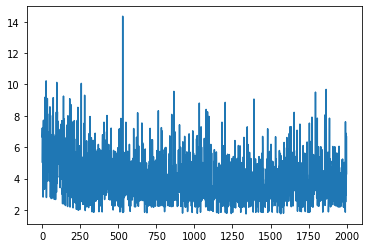

In [109]:
device = cmws.util.get_device()

max_num_chars, lstm_hidden_dim = 20, 128
generative_model = timeseries.GenerativeModel(max_num_chars, lstm_hidden_dim).to(device)

batch_size = 10
num_iterations = 2000

pretrain_expression_prior(generative_model, batch_size, num_iterations)

In [110]:
import cmws.examples.timeseries.lstm_util as lstm_util

In [111]:
def sample_expression(generative_model, num_samples):
    x, eos = generative_model.expression_dist.sample([num_samples])
    num_timesteps = lstm_util.get_num_timesteps(eos)
    expression = []
    for i in range(num_samples):
        expression.append(timeseries_util.get_expression(x[i, :num_timesteps[i]]))
    return expression

In [120]:
num_samples = 100
print("\n".join(sample_expression(generative_model, num_samples)))

R+E
E
C*E*E*(W)
W
(C)
W
C
R+E
E
E
E
R
W+R
R*R*E
W+C+C+R
R
(
E
(E)
E
E+E
E
R
R
R*E
(
(
C
R
E*W+(E)*E+E+E
E
(
R
E+C*E*R+E
C
E
E*W*E
C*C*C
(
C
W
W
E
W
C*E
E
E
E
C
E
C
W
C
W*C+(
W
C+(
E
C
R
R
R
E+(
C
E
E
E
C+E
C
E
E+W*R
E
E
C*E
R*(
E
R
E
R
W
E+(C+
(
R
R*W+E
E
(
R*(
W+C*W+W+R*R*E
W
C
C
C
W
R+(R)*R*E
(W)
E*(
E
C
W
(
W
